In [103]:
# Imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn import svm
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
import numpy as np
%matplotlib inline

In [104]:
# Load dataset
data = pd.read_csv('./dataset/income.csv')

## CSI 4106 Introduction to Artificial Intelligence
#### PROJECT 1 Classification Empirical Study
Ara Kirijian 300062347 <br />
Austin Fan 300018056 <br />
<small>November 1, 2022</small>  

### 1. Our Dataset
The goal of this dataset is to determine if an individual has an income greater then fifty-thousand dollars. As such it is a binary classification task. There are niche applications for such a model, such as determining if someone is in need of financial aid. We selected it because it has a good number of comprehensive features, a large number of training examples and a mix of continuous and discrete features.


### 2. Data Analysis

This is a dataset of 32,561 training examples, it has 13 features: 
- `age` - continuous
- `workclass` - discrete
- `education` - discrete
- `education-num` - continuous
- `marital-status` - discrete
- `occupation` - discrete
- `relationship` - discrete
- `race` - discrete
- `sex` - discrete
- `capital-gain` - continuous
- `capital-loss` - continuous
- `hours-per-week` - continuous
- `native-country` - discrete

Our target variable is `income >50k` which is a binary variable.

In total there are 5 continuous features and 8 discrete features. However, since `education` and `education-num` are the same feature simply encoded differently, we really have 4 continuous features. There is some missing data in the `workclass`, `occupation` and `native-country` features. We will deal with this in the following section. It is also worth noting that the dataset is quite imbalanced, with only 24% of the training examples having an income greater than 50k. This will be important to keep in mind when we evaluate our models.

In [105]:
data.head()

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income >50K
0,66,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


In [106]:
data.isnull().sum()

age                  0
workclass         1836
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
income >50K          0
dtype: int64

##### Feature Distribution

In [107]:
## Start by splitting the data into our continuous and discrete features
continuous_features = [v for v in data.columns if data[v].dtype != 'object']
discrete_features = [v for v in data.columns if data[v].dtype == 'object']

C:\Users\arahu\AppData\Local\Temp\ipykernel_27412\4088886572.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[col])
C:\Users\arahu\AppData\Local\Temp\ipykernel_27412\4088886572.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[col])
C:\Users\arahu\AppData\Local\Temp\ipykernel_2741

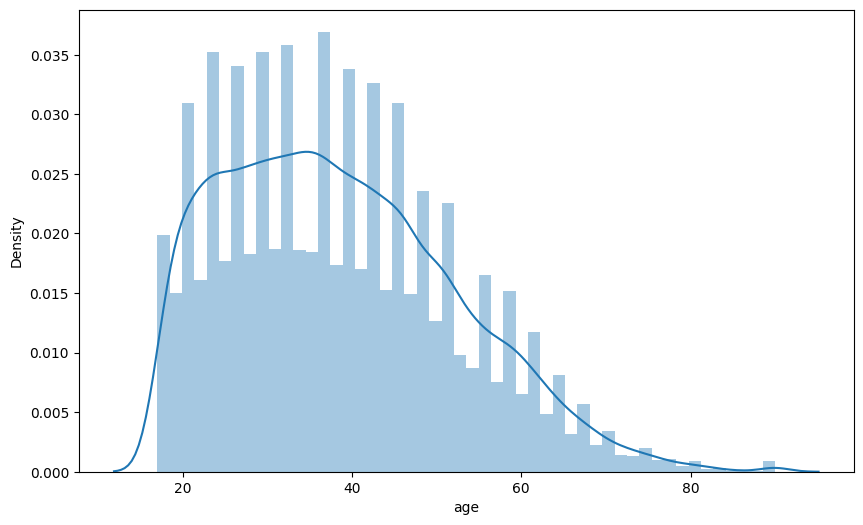

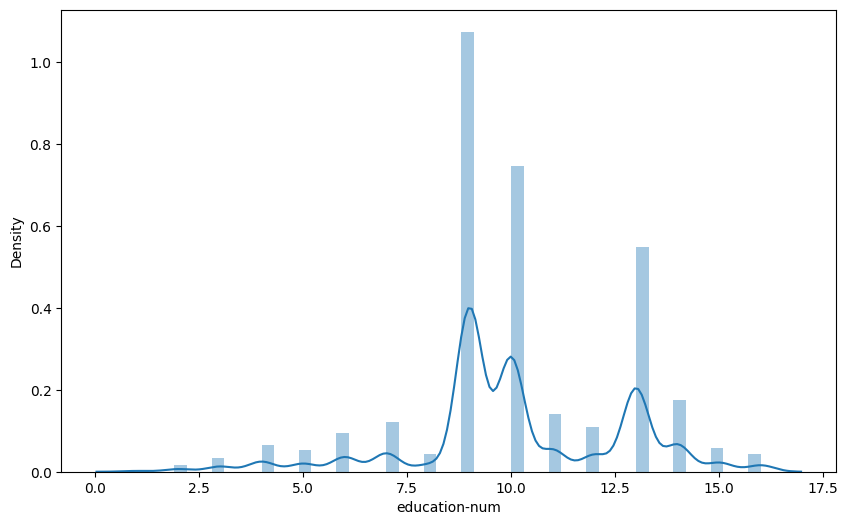

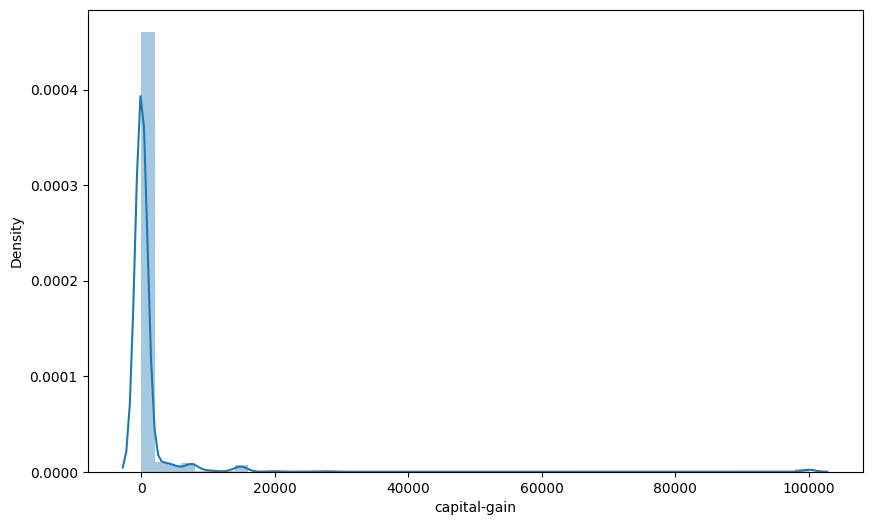

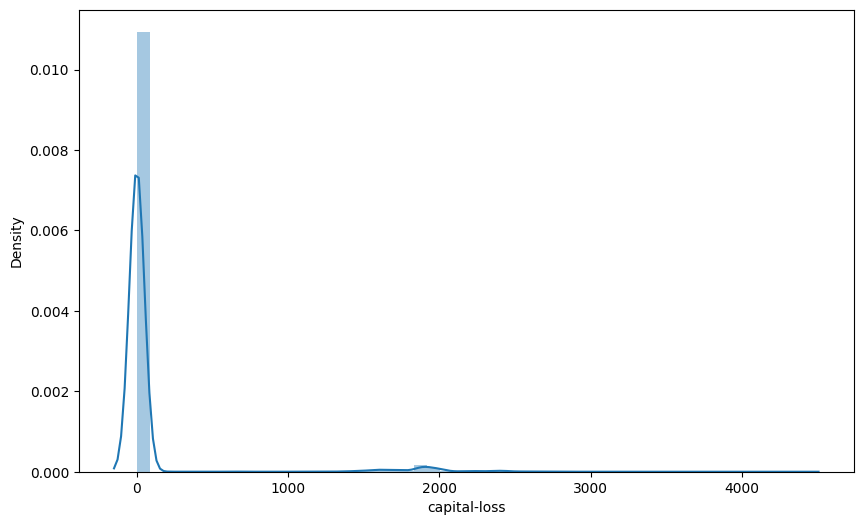

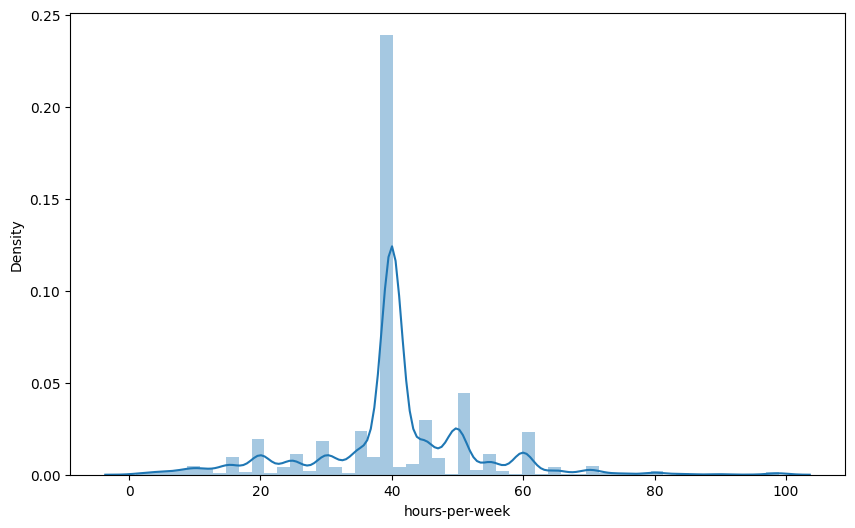

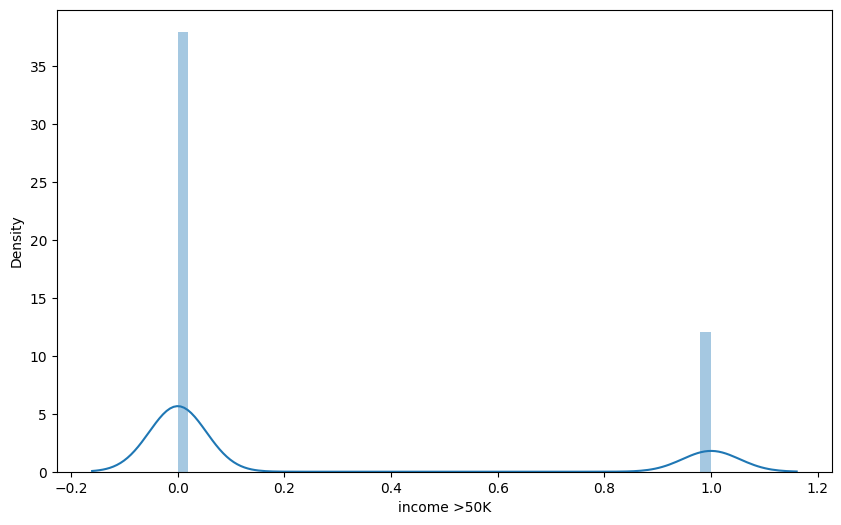

In [108]:
## Start with the continuous features
for col in continuous_features:
    plt.figure(figsize=(10, 6))
    sns.distplot(data[col])

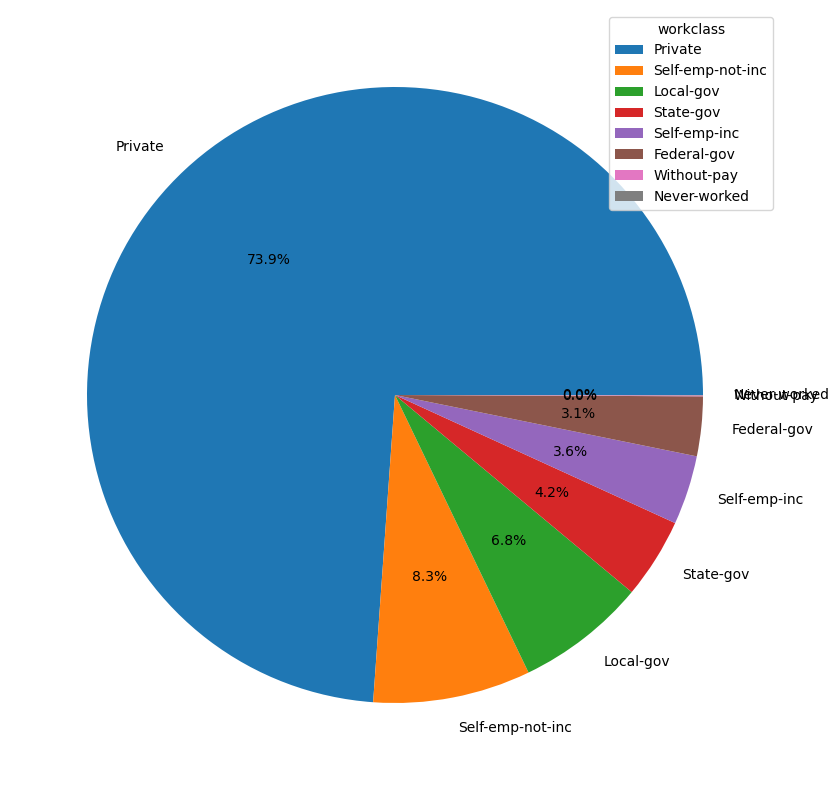

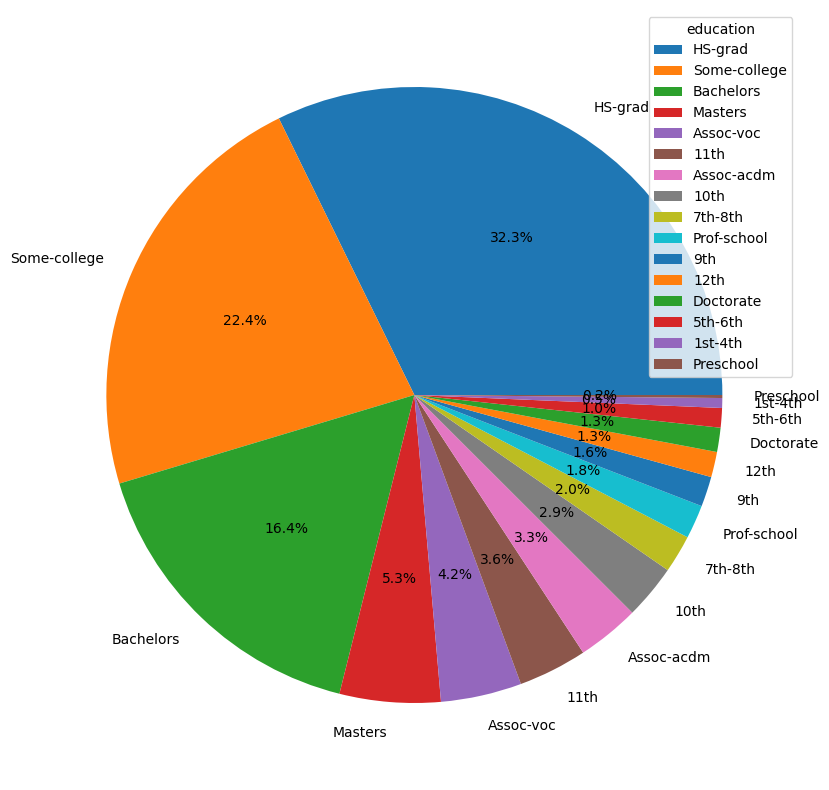

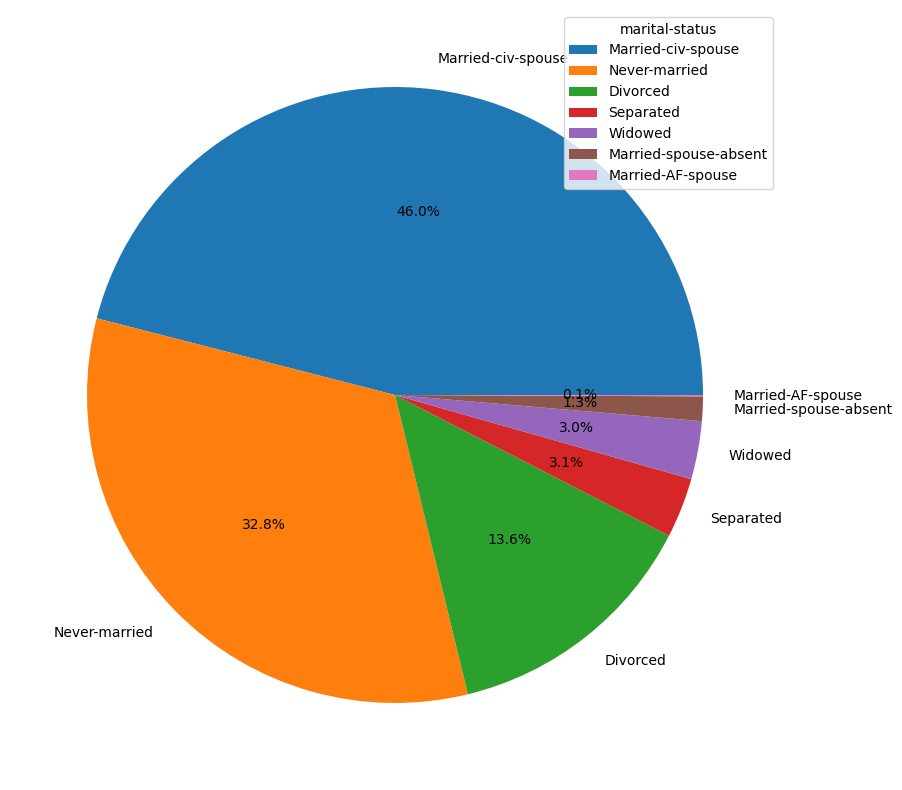

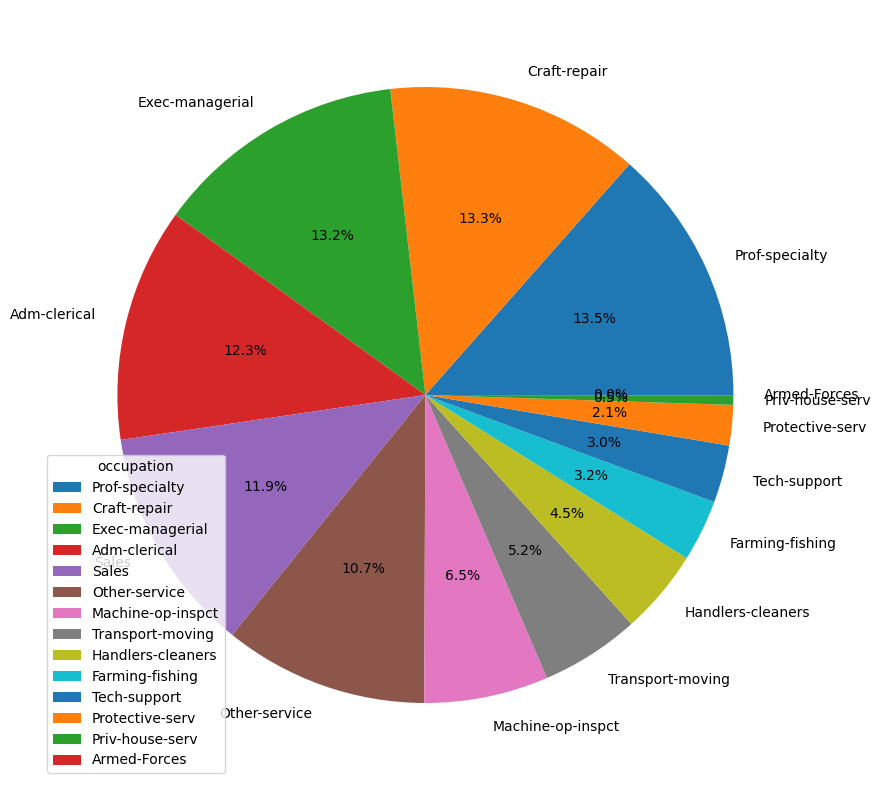

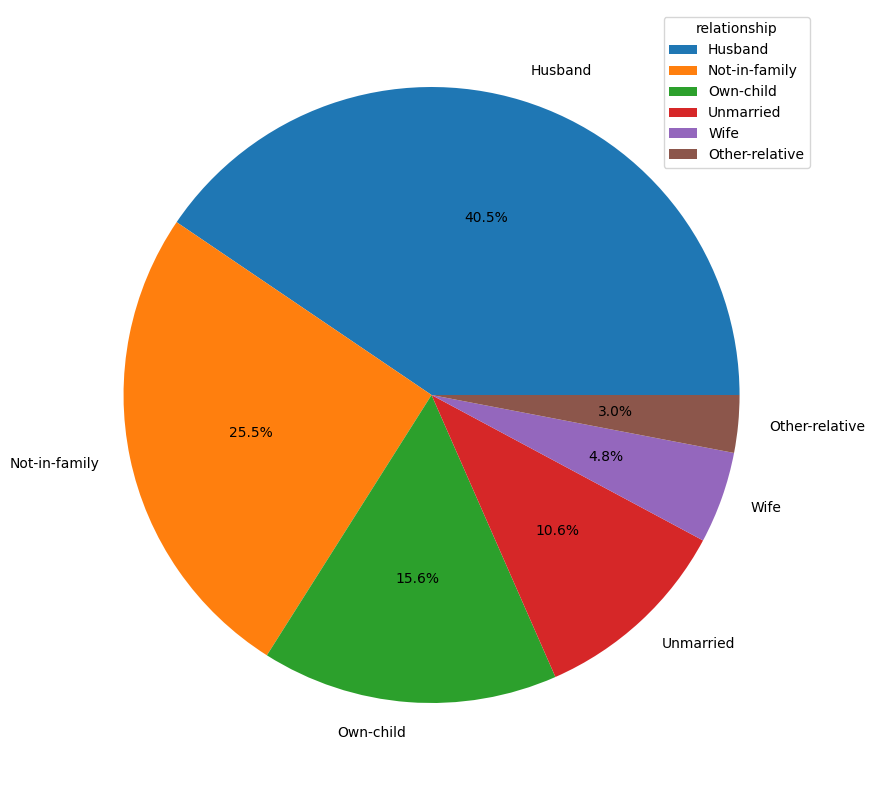

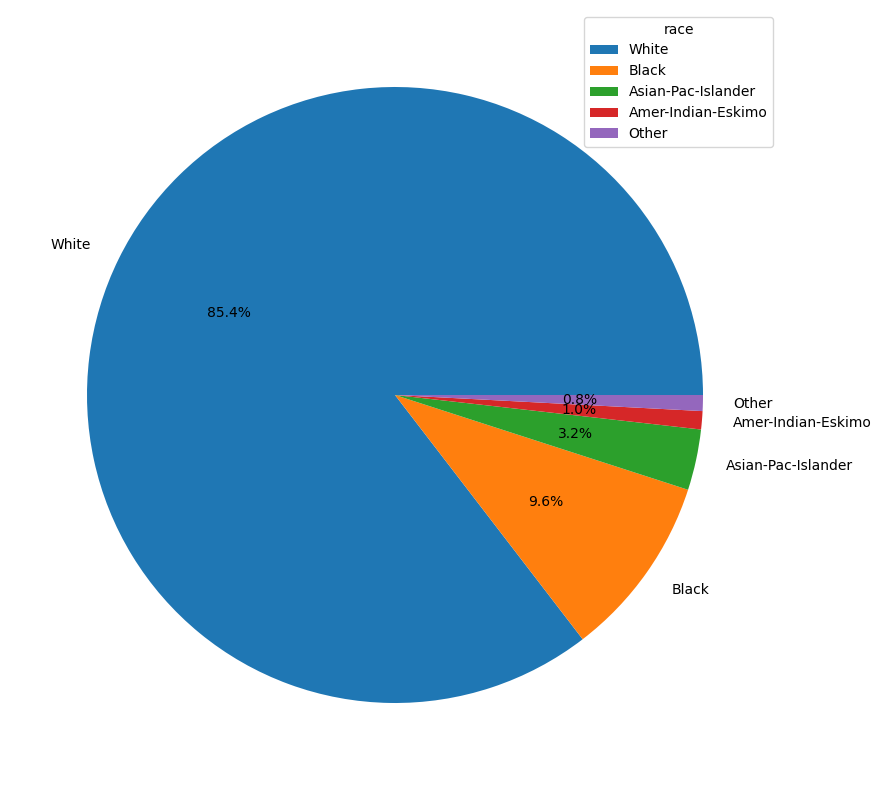

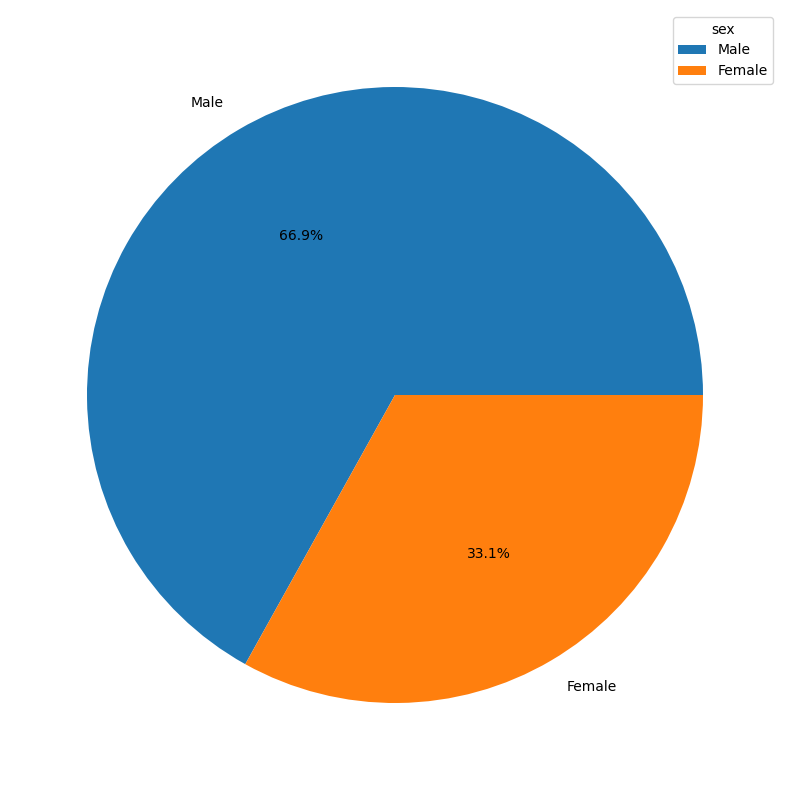

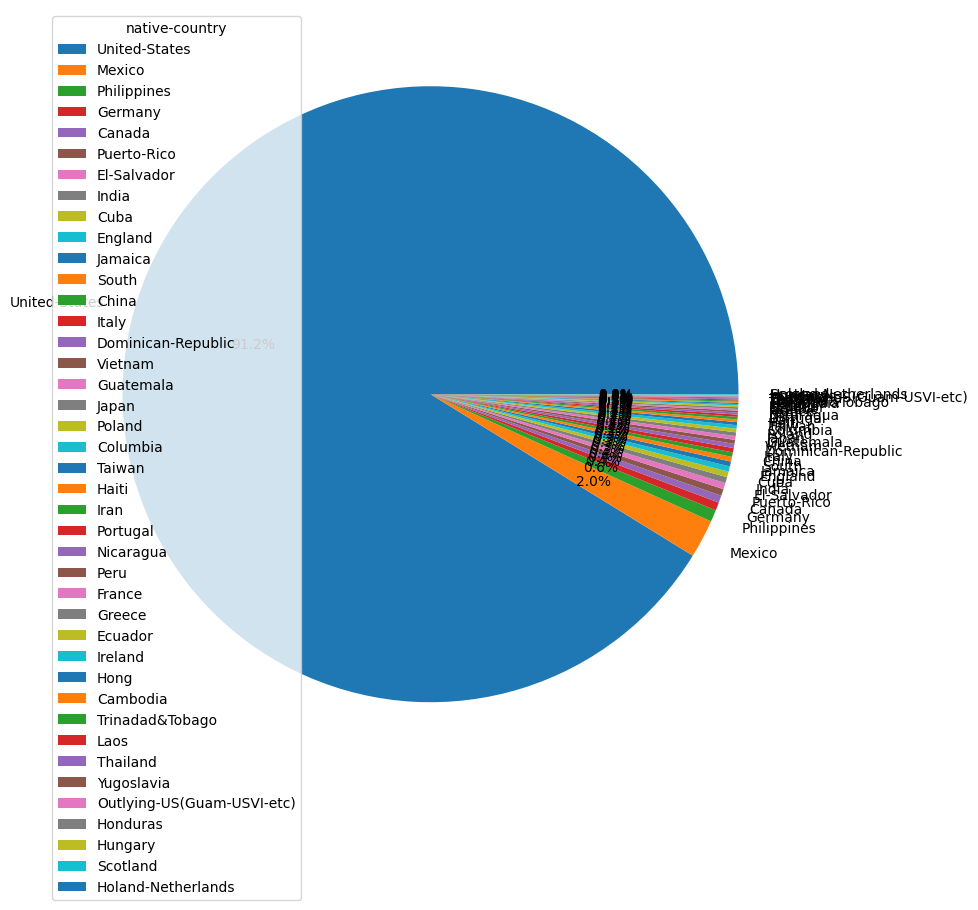

In [109]:
for col in discrete_features:
  plt.figure(figsize=(10,10))
  plt.pie(data[col].value_counts(), labels=data[col].value_counts().index, autopct='%1.1f%%')
  plt.legend(title = col)
  plt.show()

### 3. Feature Engineering
*Think about the features that could be useful for this task, are they all present in the
dataset? Anything missing? Any attribute provided that doesn’t seem useful to you?*

For the most part we don't believe there to be any missing attributes as the features feel like a comprehensive list of what could be useful for this task. The one feature we think is missing is the location of the individual as some areas are wealthier then others. It could therefore be a good indicator of income. Since, `education-num` and `education` are the same feature, we will drop `education-num` as it is more abstract and less interpretable. 

As previously mentioned, there are 3 features with missing data, `workclass`, `occupation` and `native-country`. For the first 2, we are going to make the assumption that the missing value is due to the individual not being employed, we will therefore replace the missing data with the value `Unemployed`. The `native-country` feature is a bit more complicated, but given that the majority of the dataset are United-States citizens, we will make the assumption that they are from the United-States.

In [110]:
# Drop education-num
data.drop('education-num', axis=1, inplace=True)

# Replace the values in the native-country column with `United-States`
data['native-country'].fillna('United-States', inplace=True)


# Replace missing values in workclass and occupation with 'unemployed'
data['workclass'].fillna('unemployed', inplace=True)
data['occupation'].fillna('unemployed', inplace=True)

### 4. Encode the Features
*As you will use models that need discrete or continuous attributes, think about data encoding and transformation*

We will need to encode the data in two different ways, once for Naive Bayes and once for the other two models. For both cases, we will encode the discrete features using one-hot encoding. For the continuous features however we will need to do something different. For Naive Bayes, we will use binning to discretize the continuous features. For the other two models, we will use standardization to normalize the continuous features.

#### a) Naive Bayes

For the Naive Bayes model, we will use the `Robust Scaler` to scale the continuous features. We are using this scaler as it is less sensitive to outliers then the `Standard Scaler`. We will also use the `Label Encoder` to encode the discrete features.

##### Continuous Features

In [111]:
nb_X = data.drop('income >50K', axis=1)
nb_y = data['income >50K']

In [112]:
discrete_features = [v for v in nb_X.columns if nb_X[v].dtype == 'object']
continuous_features = [v for v in nb_X.columns if nb_X[v].dtype != 'object']

## Scale the continuous features
scaler = RobustScaler()

nb_X[continuous_features] = scaler.fit_transform(nb_X[continuous_features])
nb_X.head()

,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,1.45,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,0.0,United-States
1,0.65,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,-5.4,United-States
2,0.05,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,0.0,United-States
3,0.80,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,0.0,United-States
4,-0.45,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,0.0,Cuba


##### Discrete Features

In [113]:
# enc = OneHotEncoder()

# enc_feat = enc.fit_transform(nb_X[discrete_features]).toarray()
# enc_feat = pd.DataFrame(enc_feat, columns=np.hstack(enc.categories_))
# enc_feat.head()

# nb_X = pd.concat([nb_X[continuous_features], enc_feat], axis=1)
# nb_X.head()

In [114]:
from sklearn.preprocessing import LabelEncoder

enc = LabelEncoder()

nb_X[discrete_features] = nb_X[discrete_features].apply(enc.fit_transform) 
nb_X.head()

,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,1.45,6,9,4,0,1,4,1,2174.0,0.0,0.0,38
1,0.65,5,9,2,3,0,4,1,0.0,0.0,-5.4,38
2,0.05,3,11,0,5,1,4,1,0.0,0.0,0.0,38
3,0.80,3,1,2,5,0,2,1,0.0,0.0,0.0,38
4,-0.45,3,9,2,9,5,2,0,0.0,0.0,0.0,4


#### b) Logistic Regression
For our Logistic Regression we will use the `MinMaxScaler` to normalize our continuous features and the `One Hot Encoder` to encode the discrete features.

In [116]:
lr_X = data.drop('income >50K', axis=1)
ly_y = data['income >50K']

##### Continuous Features

In [117]:
## Normalize the continuous features
from sklearn.preprocessing import MinMaxScaler

lr_X[continuous_features] = MinMaxScaler().fit_transform(lr_X[continuous_features])
lr_X.head()

,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.671233,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,0.02174,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.00000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.00000,0.0,0.397959,United-States
3,0.493151,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.00000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.00000,0.0,0.397959,Cuba


##### Discrete Features

In [118]:
## Encode the discrete features using one hot encoding
enc = OneHotEncoder()

enc_feat = enc.fit_transform(lr_X[discrete_features]).toarray()
enc_feat = pd.DataFrame(enc_feat, columns=np.hstack(enc.categories_))
enc_feat.head()

lr_X = pd.concat([lr_X[continuous_features], enc_feat], axis=1)
lr_X.head()

,age,capital-gain,capital-loss,hours-per-week,Federal-gov,Local-gov,Never-worked,Private,Self-emp-inc,Self-emp-not-inc,...,Portugal,Puerto-Rico,Scotland,South,Taiwan,Thailand,Trinadad&Tobago,United-States,Vietnam,Yugoslavia
0,0.671233,0.02174,0.0,0.397959,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.452055,0.00000,0.0,0.122449,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.287671,0.00000,0.0,0.397959,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.493151,0.00000,0.0,0.397959,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.150685,0.00000,0.0,0.397959,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 5-7. Data Preparation, Model Training and Cross Validation

#### a) Naive Bayes

In [126]:
# Make our folds
folds = KFold(n_splits=10, shuffle=True, random_state=42)
nb_scores = []
for train_index, test_index in folds.split(nb_X):
    # 5: Split the data into train and test
    nb_X_train, nb_X_test = nb_X.iloc[train_index], nb_X.iloc[test_index]
    nb_y_train, nb_y_test = nb_y.iloc[train_index], nb_y.iloc[test_index]
    
    # 6: Train the model
    gnb = GaussianNB()
    gnb.fit(nb_X_train, nb_y_train)

    # 7: Test the model
    score = gnb.score(nb_X_test, nb_y_test)
    print(score)
    nb_scores.append(score)

print('Average Naive Bayes Score: {:.3f}'.format(np.mean(nb_scores)))

Average Naive Bayes Score: 0.797


##### Naive Bayes Score: 0.797

#### b) Logistic Regression

In [127]:
# Make our folds
folds = KFold(n_splits=10, shuffle=True, random_state=42)
lr_scores = []
for train_index, test_index in folds.split(lr_X):
    # 5: Split the data into train and test
    lr_X_train, lr_X_test = lr_X.iloc[train_index], lr_X.iloc[test_index]
    lr_y_train, lr_y_test = ly_y.iloc[train_index], ly_y.iloc[test_index]
    
    # 6: Train the model
    lr = LogisticRegression(solver='liblinear') # We need to use the liblinear solver due to the size of our dataset
    lr.fit(lr_X_train, lr_y_train)

    # 7: Test the model
    score = lr.score(lr_X_test, lr_y_test)
    print(score)
    lr_scores.append(score)

print('Average Logistic Regression Score: {:.3f}'.format(np.mean(lr_scores)))

Average Logistic Regression Score: 0.850


##### Logistic Regression Score: 0.85

#### c) Multi-Layer Perceptron

In [128]:
# Make our folds
folds = KFold(n_splits=10, shuffle=True, random_state=42)
mlp_scores = []
for train_index, test_index in folds.split(lr_X):
    # 5: Split the data into train and test
    lr_X_train, lr_X_test = lr_X.iloc[train_index], lr_X.iloc[test_index]
    lr_y_train, lr_y_test = ly_y.iloc[train_index], ly_y.iloc[test_index]
    
    # 6: Train the model
    mlp = MLPClassifier(max_iter=1000) # We need to set max iterations to 1000 to prevent convergence warnings 
    mlp.fit(lr_X_train, lr_y_train)

    # 7: Test the model
    score = mlp.score(lr_X_test, lr_y_test)
    print(score)
    mlp_scores.append(score)

print('Average MLP Score: {:.3f}'.format(np.mean(mlp_scores)))

c:\Users\arahu\Documents\University\csi4106-project-1\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\arahu\Documents\University\csi4106-project-1\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:709: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
c:\Users\arahu\Documents\University\csi4106-project-1\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


### 8. Perform an evaluation with precision/recall measures

#### a) Naïve Bayes

True Negative: 5654
True Positive: 1937
False Negative: 1599
False Positive: 404


<AxesSubplot: >

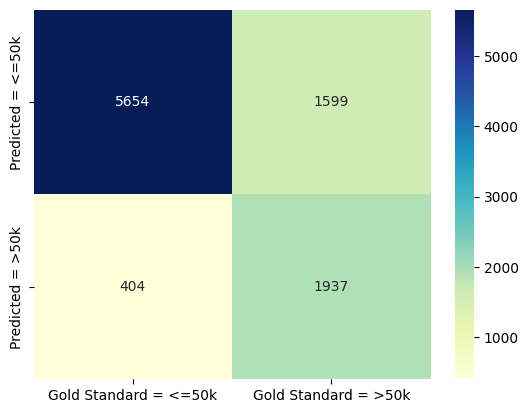

In [ ]:
nb_matrix = confusion_matrix(nb_y_test, nb_y_pred)

nb_matrixDf = pd.DataFrame(data=nb_matrix, columns=['Gold Standard = <=50k', 'Gold Standard = >50k'], index=['Predicted = <=50k', 'Predicted = >50k'])

print('True Negative:', nb_matrix[0,0])
print('True Positive:', nb_matrix[1,1])
print('False Negative:', nb_matrix[0,1])
print('False Positive:', nb_matrix[1,0])

sns.heatmap(nb_matrixDf, annot=True, fmt='d', cmap='YlGnBu')

In [ ]:
nb_report = classification_report(nb_y_test, nb_y_pred, target_names=['<=50k', '>50k'])
nb_report

              precision    recall  f1-score   support

       <=50k       0.93      0.78      0.85      7253
        >50k       0.55      0.83      0.66      2341

    accuracy                           0.79      9594
   macro avg       0.74      0.80      0.75      9594
weighted avg       0.84      0.79      0.80      9594



##### Summary of results
We notice very quickly that while our model is very precise when it comes to guessing if a person makes less then 50k a year, it is very bad at guessing if a person makes more then 50k a year. We can see this in the precision score of 0.54 for the positive class. This is most likely due to the large class imbalance in our dataset.

#### b) Logistic Regression

True Negative: 6776
True Positive: 1406
False Negative: 477
False Positive: 935


<AxesSubplot: >

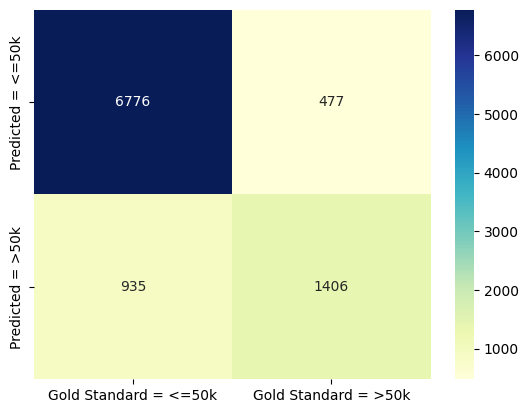

In [ ]:
lr_matrix = confusion_matrix(lr_y_test, lr_y_pred)

lr_matrixDf = pd.DataFrame(data=lr_matrix, columns=['Gold Standard = <=50k', 'Gold Standard = >50k'], index=['Predicted = <=50k', 'Predicted = >50k'])

print('True Negative:', lr_matrix[0,0])
print('True Positive:', lr_matrix[1,1])
print('False Negative:', lr_matrix[0,1])
print('False Positive:', lr_matrix[1,0])

sns.heatmap(lr_matrixDf, annot=True, fmt='d', cmap='YlGnBu')

In [ ]:
lr_report = classification_report(lr_y_test, lr_y_pred, target_names=['<=50k', '>50k'])
print(lr_report)

              precision    recall  f1-score   support

       <=50k       0.88      0.93      0.91      7253
        >50k       0.75      0.60      0.67      2341

    accuracy                           0.85      9594
   macro avg       0.81      0.77      0.79      9594
weighted avg       0.85      0.85      0.85      9594



##### Summary of Results
Unlike our Naive Bayes model, our Logistic Regression model is much more precise when it comes to guessing if a person makes more then 50k a year. However, it's recall score is much lower then our Naive Bayes model. The model overall seems much more hesitant to say an individual makes more then 50k a year when compared to Naive Bayes

#### c) Multi-Layer Perceptron

True Negative: 6624
True Positive: 1478
False Negative: 629
False Positive: 863


<AxesSubplot: >

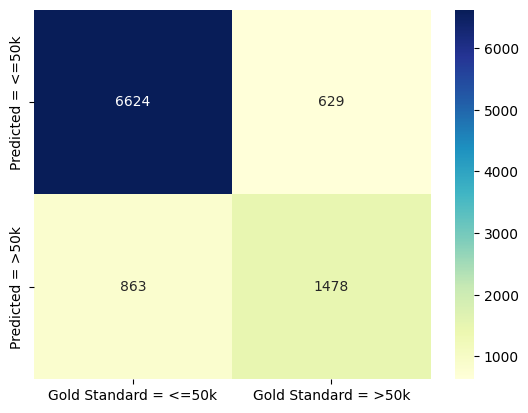

In [ ]:
mlp_matrix = confusion_matrix(mlp_y_test, mlp_y_pred)

mlp_matrixDf = pd.DataFrame(data=mlp_matrix, columns=['Gold Standard = <=50k', 'Gold Standard = >50k'], index=['Predicted = <=50k', 'Predicted = >50k'])

print('True Negative:', mlp_matrix[0,0])
print('True Positive:', mlp_matrix[1,1])
print('False Negative:', mlp_matrix[0,1])
print('False Positive:', mlp_matrix[1,0])

sns.heatmap(mlp_matrixDf, annot=True, fmt='d', cmap='YlGnBu')

In [ ]:
mlp_report = classification_report(mlp_y_test, mlp_y_pred, target_names=['<=50k', '>50k'])
print(mlp_report)

              precision    recall  f1-score   support

       <=50k       0.88      0.91      0.90      7253
        >50k       0.70      0.63      0.66      2341

    accuracy                           0.84      9594
   macro avg       0.79      0.77      0.78      9594
weighted avg       0.84      0.84      0.84      9594



##### Summary of results
Again, our MLP model has a better precision score for the positive class then our Naive Bayes model while having a much lower recall score.

### 9. For each type of model, modify some parameters and perform a train/test/evaluate again. Do this twice for each model. 

#### 9.1 Naïve Bayes

##### Run 2
GuassianNB only has two parameters, `var_smoothing` and `priors`. We will only modify `var_smoothing`

Training the model

In [ ]:
# Default var smoothing is 1e-9, we will try 1e-11 to see it's effects (if any)
gnb_2 = GaussianNB(var_smoothing=1e-11)

gnb_2.fit(nb_X_train, nb_y_train)

nb_y_pred_2 = gnb_2.predict(nb_X_test)

print('Model accuracy score: {0:0.4f}'. format(accuracy_score(nb_y_test, nb_y_pred_2)))

Model accuracy score: 0.7206


Test using cross-validation

In [ ]:
nb_kf = KFold(n_splits=10)
total_acc = 0
for train_index, test_index in nb_kf2.split(nb_X):
    X_train, X_test = nb_X.iloc[train_index], nb_X.iloc[test_index]
    y_train, y_test = nb_y.iloc[train_index], nb_y.iloc[test_index]
    mlp.fit(X_train, y_train)
    y_pred = mlp.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    total_acc += acc
    print('Model accuracy score: {0:0.4f}'. format(acc))

print('Average cross-validation score: {:.4f}'.format(total_acc/10))

Model accuracy score: 0.8440
Model accuracy score: 0.8521
Model accuracy score: 0.8452
Model accuracy score: 0.8396
Model accuracy score: 0.8343
Model accuracy score: 0.8552
Model accuracy score: 0.8602
Model accuracy score: 0.8627
Model accuracy score: 0.8424
Model accuracy score: 0.8389
Average cross-validation score: 0.8475


Evaluation

True Negative: 5654
True Positive: 1937
False Negative: 1599
False Positive: 404


<AxesSubplot: >

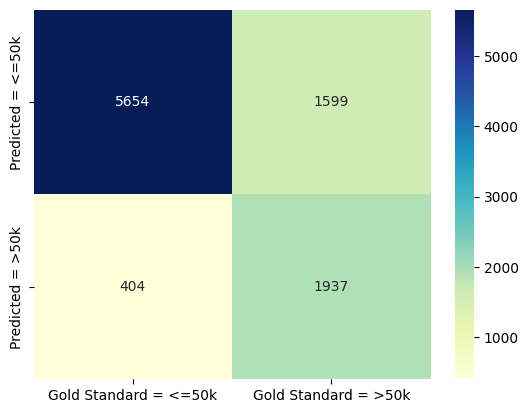

In [ ]:
# Confusion Matrix
nb2_matrix = confusion_matrix(nb_y_test, nb_y_pred)

nb2_matrixDf = pd.DataFrame(data=nb2_matrix, columns=['Gold Standard = <=50k', 'Gold Standard = >50k'], index=['Predicted = <=50k', 'Predicted = >50k'])

print('True Negative:', nb2_matrix[0,0])
print('True Positive:', nb2_matrix[1,1])
print('False Negative:', nb2_matrix[0,1])
print('False Positive:', nb2_matrix[1,0])

sns.heatmap(nb2_matrixDf, annot=True, fmt='d', cmap='YlGnBu')

In [ ]:
# Classification Report
nb2_report = classification_report(nb_y_test, nb_y_pred_2, target_names=['<=50k', '>50k'])
print(nb2_report)

              precision    recall  f1-score   support

       <=50k       0.95      0.67      0.78      7253
        >50k       0.46      0.89      0.61      2341

    accuracy                           0.72      9594
   macro avg       0.71      0.78      0.70      9594
weighted avg       0.83      0.72      0.74      9594



##### Run 3

Training the model

In [ ]:
## This time we will try increasing our var_smoothing to 1e-7
gnb_3 = GaussianNB(var_smoothing=1e-7)

gnb_3.fit(nb_X_train, nb_y_train)

nb_y_pred_3 = gnb_3.predict(nb_X_test)

print('Model accuracy score: {0:0.4f}'. format(accuracy_score(nb_y_test, nb_y_pred_3)))

Model accuracy score: 0.7985


Test using cross-validation

In [ ]:
nb_kf = KFold(n_splits=10)
total_acc = 0
for train_index, test_index in nb_kf2.split(nb_X):
    X_train, X_test = nb_X.iloc[train_index], nb_X.iloc[test_index]
    y_train, y_test = nb_y.iloc[train_index], nb_y.iloc[test_index]
    mlp.fit(X_train, y_train)
    y_pred = mlp.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    total_acc += acc
    print('Model accuracy score: {0:0.4f}'. format(acc))

print('Average cross-validation score: {:.4f}'.format(total_acc/10))

Model accuracy score: 0.8471
Model accuracy score: 0.8508
Model accuracy score: 0.8180
Model accuracy score: 0.8505
Model accuracy score: 0.8552
Model accuracy score: 0.8649
Model accuracy score: 0.8474
Model accuracy score: 0.8558
Model accuracy score: 0.8646
Model accuracy score: 0.8564
Average cross-validation score: 0.8511


Evaluation

True Negative: 6930
True Positive: 731
False Negative: 323
False Positive: 1610


<AxesSubplot: >

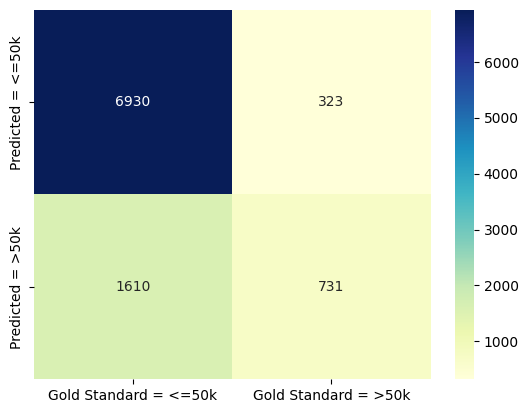

In [ ]:
# Confusion Matrix
nb3_matrix = confusion_matrix(nb_y_test, nb_y_pred_3)

nb3_matrixDf = pd.DataFrame(data=nb3_matrix, columns=['Gold Standard = <=50k', 'Gold Standard = >50k'], index=['Predicted = <=50k', 'Predicted = >50k'])

print('True Negative:', nb3_matrix[0,0])
print('True Positive:', nb3_matrix[1,1])
print('False Negative:', nb3_matrix[0,1])
print('False Positive:', nb3_matrix[1,0])

sns.heatmap(nb3_matrixDf, annot=True, fmt='d', cmap='YlGnBu')

In [ ]:
# Classification Report
nb3_report = classification_report(nb_y_test, nb_y_pred_3, target_names=['<=50k', '>50k'])
print(nb3_report)

              precision    recall  f1-score   support

       <=50k       0.81      0.96      0.88      7253
        >50k       0.69      0.31      0.43      2341

    accuracy                           0.80      9594
   macro avg       0.75      0.63      0.65      9594
weighted avg       0.78      0.80      0.77      9594



##### Summary of results  

For our second run, we decreased our variable smoothing and noticed that our accuracy went down by a significant amount (from 0.77 to 0.72). We also notice in our classification report that our precision score for the positive class went down by a significant amount (from 0.54 to 0.48). This shows that increasing the variable smoothing decreases the precision of our model.

For our third run, we did the opposite. The accuracy of our model doesn't seem to have been significantly affected (from 0.77 to 0.79). However we see in our classification report that our recall score for the positive class went down by a very large amount (from 0.83 to 0.31). 

#### 9.2 Logistic Regression

##### Run 2
For our second run, we will try to change our penalty from 'l2' to 'l1'.

Training the model

In [ ]:
lr_2 = LogisticRegression(solver='liblinear', penalty='l1')
lr_2.fit(lr_X_train, lr_y_train)

lr_y_pred_2 = lr_2.predict(lr_X_test)

print('Model accuracy score: {0:0.4f}'. format(accuracy_score(lr_y_test, lr_y_pred_2)))

Model accuracy score: 0.8569


Test using cross-validation

In [ ]:
lr_kf = KFold(n_splits=10)
total_acc = 0
for train_index, test_index in lr_kf.split(lr_X):
    X_train, X_test = lr_X.iloc[train_index], lr_X.iloc[test_index]
    y_train, y_test = lr_y.iloc[train_index], lr_y.iloc[test_index]
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    total_acc += acc
    print('Model accuracy score: {0:0.4f}'. format(acc))

print('Average cross-validation score: {:.4f}'.format(total_acc/10))

Model accuracy score: 0.8430
Model accuracy score: 0.8524
Model accuracy score: 0.8543
Model accuracy score: 0.8393
Model accuracy score: 0.8502
Model accuracy score: 0.8521
Model accuracy score: 0.8540
Model accuracy score: 0.8549
Model accuracy score: 0.8546
Model accuracy score: 0.8461
Average cross-validation score: 0.8501


Evaluation

True Negative: 6785
True Positive: 1436
False Negative: 468
False Positive: 905


<AxesSubplot: >

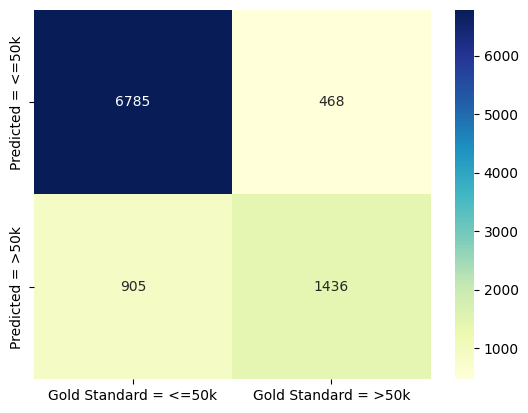

In [ ]:
# Confusion Matrix
lr2_matrix = confusion_matrix(lr_y_test, lr_y_pred_2)

lr2_matrixDf = pd.DataFrame(data=lr2_matrix, columns=['Gold Standard = <=50k', 'Gold Standard = >50k'], index=['Predicted = <=50k', 'Predicted = >50k'])

print('True Negative:', lr2_matrix[0,0])
print('True Positive:', lr2_matrix[1,1])
print('False Negative:', lr2_matrix[0,1])
print('False Positive:', lr2_matrix[1,0])

sns.heatmap(lr2_matrixDf, annot=True, fmt='d', cmap='YlGnBu')

In [ ]:
# Classification Report
lr2_report = classification_report(lr_y_test, lr_y_pred_2, target_names=['<=50k', '>50k'])
print(lr2_report)

              precision    recall  f1-score   support

       <=50k       0.88      0.94      0.91      7253
        >50k       0.75      0.61      0.68      2341

    accuracy                           0.86      9594
   macro avg       0.82      0.77      0.79      9594
weighted avg       0.85      0.86      0.85      9594



##### Run 3

For this run, we will add inverse regularization by setting `C` to 0.2 from 1. Making C smaller increases the regularization strength.

Trainning the model

In [ ]:
lr_3 = LogisticRegression(solver='liblinear', C=0.2)
lr_3.fit(lr_X_train, lr_y_train)

lr_y_pred_3 = lr_3.predict(lr_X_test)

print('Model accuracy score: {0:0.4f}'. format(accuracy_score(lr_y_test, lr_y_pred_3)))

Model accuracy score: 0.8480


Test using cross-validation

In [ ]:
lr_kf = KFold(n_splits=10)
total_acc = 0
for train_index, test_index in lr_kf.split(lr_X):
    X_train, X_test = lr_X.iloc[train_index], lr_X.iloc[test_index]
    y_train, y_test = lr_y.iloc[train_index], lr_y.iloc[test_index]
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    total_acc += acc
    print('Model accuracy score: {0:0.4f}'. format(acc))

print('Average cross-validation score: {:.4f}'.format(total_acc/10))

Model accuracy score: 0.8430
Model accuracy score: 0.8524
Model accuracy score: 0.8543
Model accuracy score: 0.8393
Model accuracy score: 0.8502
Model accuracy score: 0.8521
Model accuracy score: 0.8540
Model accuracy score: 0.8549
Model accuracy score: 0.8546
Model accuracy score: 0.8461
Average cross-validation score: 0.8501


Evaluation

True Negative: 6771
True Positive: 1365
False Negative: 482
False Positive: 976


<AxesSubplot: >

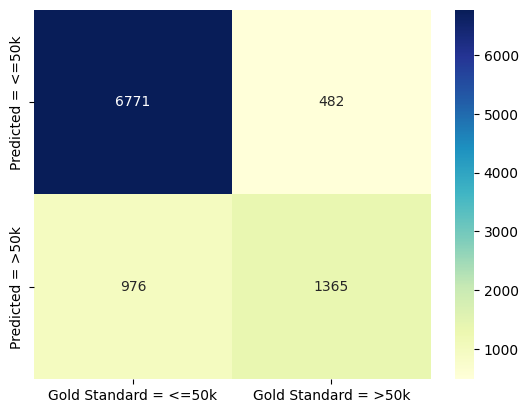

In [ ]:
# Confusion Matrix
lr3_matrix = confusion_matrix(lr_y_test, lr_y_pred_3)

lr3_matrixDf = pd.DataFrame(data=lr3_matrix, columns=['Gold Standard = <=50k', 'Gold Standard = >50k'], index=['Predicted = <=50k', 'Predicted = >50k'])

print('True Negative:', lr3_matrix[0,0])
print('True Positive:', lr3_matrix[1,1])
print('False Negative:', lr3_matrix[0,1])
print('False Positive:', lr3_matrix[1,0])

sns.heatmap(lr3_matrixDf, annot=True, fmt='d', cmap='YlGnBu')

In [ ]:
# Classification Report
lr3_report = classification_report(lr_y_test, lr_y_pred_3, target_names=['<=50k', '>50k'])
print(lr3_report)

              precision    recall  f1-score   support

       <=50k       0.87      0.93      0.90      7253
        >50k       0.74      0.58      0.65      2341

    accuracy                           0.85      9594
   macro avg       0.81      0.76      0.78      9594
weighted avg       0.84      0.85      0.84      9594



##### Summary of results
Interestingly, our classification reports show that our logistic regression had little to no changes regardless of the settings we changed.

#### 9.3 Multi-Layer Perceptron

##### Run 2

For our second Multi-layer perceptron, we will try to increase the number of hidden layers.

Training the model

In [ ]:
mlp_2 = MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=1000) # 2 hidden layers with 100 neurons each, 1000 iterations to avoid convergence warning
mlp_2.fit(mlp_X_train, mlp_y_train)

mlp_y_pred_2 = mlp_2.predict(mlp_X_test)

print('Model accuracy score: {0:0.4f}'. format(accuracy_score(mlp_y_test, mlp_y_pred_2)))

Model accuracy score: 0.8306


Test using cross-validation

In [ ]:
mlp_kf = KFold(n_splits=10)
total_acc = 0
for train_index, test_index in mlp_kf.split(mlp_X):
    X_train, X_test = mlp_X.iloc[train_index], mlp_X.iloc[test_index]
    y_train, y_test = mlp_y.iloc[train_index], mlp_y.iloc[test_index]
    mlp.fit(X_train, y_train)
    y_pred = mlp.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    total_acc += acc
    print('Model accuracy score: {0:0.4f}'. format(acc))

print('Average cross-validation score: {:.4f}'.format(total_acc/10))

Model accuracy score: 0.8355
Model accuracy score: 0.8399
Model accuracy score: 0.8527
Model accuracy score: 0.8346
Model accuracy score: 0.8468
Model accuracy score: 0.8527
Model accuracy score: 0.8430
Model accuracy score: 0.8540
Model accuracy score: 0.8552
Model accuracy score: 0.8383
Average cross-validation score: 0.8453


Evaluation

True Negative: 6336
True Positive: 1633
False Negative: 917
False Positive: 708


<AxesSubplot: >

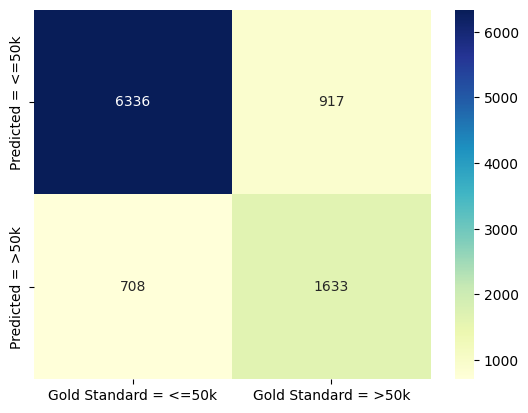

In [ ]:
# Confusion Matrix
mlp3_matrix = confusion_matrix(mlp_y_test, mlp_y_pred_2)

mlp3_matrixDf = pd.DataFrame(data=mlp3_matrix, columns=['Gold Standard = <=50k', 'Gold Standard = >50k'], index=['Predicted = <=50k', 'Predicted = >50k'])

print('True Negative:', mlp3_matrix[0,0])
print('True Positive:', mlp3_matrix[1,1])
print('False Negative:', mlp3_matrix[0,1])
print('False Positive:', mlp3_matrix[1,0])

sns.heatmap(mlp3_matrixDf, annot=True, fmt='d', cmap='YlGnBu')

In [ ]:
# Classification Report
mlp2_report = classification_report(mlp_y_test, mlp_y_pred_2, target_names=['<=50k', '>50k'])
print(mlp2_report)

              precision    recall  f1-score   support

       <=50k       0.90      0.87      0.89      7253
        >50k       0.64      0.70      0.67      2341

    accuracy                           0.83      9594
   macro avg       0.77      0.79      0.78      9594
weighted avg       0.84      0.83      0.83      9594



##### Run 3

For our final run, we will try changing the number of neurons in our hidden layer.

Training the model

In [ ]:
mlp_3 = MLPClassifier(hidden_layer_sizes=(200), max_iter=1000) # 1 hidden layer with 200 neurons, 1000 iterations to avoid convergence warning
mlp_3.fit(mlp_X_train, mlp_y_train)

mlp_y_pred_3 = mlp_3.predict(mlp_X_test)

print('Model accuracy score: {0:0.4f}'. format(accuracy_score(mlp_y_test, mlp_y_pred_3)))

Model accuracy score: 0.8413


Test using cross-validation

In [ ]:
mlp_kf = KFold(n_splits=10)
total_acc = 0
for train_index, test_index in mlp_kf.split(mlp_X):
    X_train, X_test = mlp_X.iloc[train_index], mlp_X.iloc[test_index]
    y_train, y_test = mlp_y.iloc[train_index], mlp_y.iloc[test_index]
    mlp.fit(X_train, y_train)
    y_pred = mlp.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    total_acc += acc
    print('Model accuracy score: {0:0.4f}'. format(acc))

print('Average cross-validation score: {:.4f}'.format(total_acc/10))

Model accuracy score: 0.8440
Model accuracy score: 0.8340
Model accuracy score: 0.8493
Model accuracy score: 0.8349
Model accuracy score: 0.8402
Model accuracy score: 0.8552
Model accuracy score: 0.8455
Model accuracy score: 0.8474
Model accuracy score: 0.8536
Model accuracy score: 0.8305
Average cross-validation score: 0.8435


Evaluation

True Negative: 6659
True Positive: 1412
False Negative: 594
False Positive: 929


<AxesSubplot: >

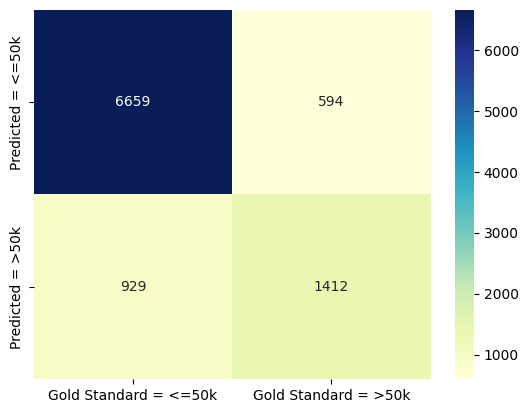

In [ ]:
# Confusion Matrix
mlp3_matrix = confusion_matrix(mlp_y_test, mlp_y_pred_3)

mlp3_matrixDf = pd.DataFrame(data=mlp3_matrix, columns=['Gold Standard = <=50k', 'Gold Standard = >50k'], index=['Predicted = <=50k', 'Predicted = >50k'])

print('True Negative:', mlp3_matrix[0,0])
print('True Positive:', mlp3_matrix[1,1])
print('False Negative:', mlp3_matrix[0,1])
print('False Positive:', mlp3_matrix[1,0])

sns.heatmap(mlp3_matrixDf, annot=True, fmt='d', cmap='YlGnBu')

In [ ]:
# Classification Report
mlp3_report = classification_report(mlp_y_test, mlp_y_pred_3, target_names=['<=50k', '>50k'])
print(mlp3_report)

              precision    recall  f1-score   support

       <=50k       0.88      0.92      0.90      7253
        >50k       0.70      0.60      0.65      2341

    accuracy                           0.84      9594
   macro avg       0.79      0.76      0.77      9594
weighted avg       0.84      0.84      0.84      9594



#### Summary of results

### 10. Analyze the obtained results

##### a) *Compare quantitatively (with the precision/recall measures) your 9 results. The 9 results come from 3 models, each with default parameters from step 6 + 2 variations from step 9.*

Naive Bayes

In [ ]:
# Print our NB classification reports
print('Run 1')
print(nb_report)

print('Run 2')
print(nb2_report)

print('Run 3')
print(nb3_report)

Run 1
              precision    recall  f1-score   support

       <=50k       0.93      0.78      0.85      7253
        >50k       0.55      0.83      0.66      2341

    accuracy                           0.79      9594
   macro avg       0.74      0.80      0.75      9594
weighted avg       0.84      0.79      0.80      9594

Run 2
              precision    recall  f1-score   support

       <=50k       0.95      0.67      0.78      7253
        >50k       0.46      0.89      0.61      2341

    accuracy                           0.72      9594
   macro avg       0.71      0.78      0.70      9594
weighted avg       0.83      0.72      0.74      9594

Run 3
              precision    recall  f1-score   support

       <=50k       0.81      0.96      0.88      7253
        >50k       0.69      0.31      0.43      2341

    accuracy                           0.80      9594
   macro avg       0.75      0.63      0.65      9594
weighted avg       0.78      0.80      0.77      9594



In [ ]:
print('Average NB Precision Macro Avg: {:.2f}'.format((0.74+0.71+0.78)/3 * 100))
print('Average NB Recall Macro Avg: {:.2f}'.format((0.80+0.63+0.78)/3 * 100))
print('\n')
print('Average NB Precision Weighted Avg: {:.2f}'.format((0.84+0.83+0.78)/3 * 100))
print('Average NB Recall Weighted Avg: {:.2f}'.format((0.79+0.73+0.80)/3 * 100))

Average NB Precision Macro Avg: 74.33
Average NB Recall Macro Avg: 73.67


Average NB Precision Weighted Avg: 81.67
Average NB Recall Weighted Avg: 77.33


Logistic Regression

In [ ]:
# Print our LR classification reports
print('Run 1')
print(lr_report)

print('Run 2')
print(lr2_report)

print('Run 3')
print(lr3_report)

Run 1
              precision    recall  f1-score   support

       <=50k       0.88      0.93      0.91      7253
        >50k       0.75      0.60      0.67      2341

    accuracy                           0.85      9594
   macro avg       0.81      0.77      0.79      9594
weighted avg       0.85      0.85      0.85      9594

Run 2
              precision    recall  f1-score   support

       <=50k       0.88      0.94      0.91      7253
        >50k       0.75      0.61      0.68      2341

    accuracy                           0.86      9594
   macro avg       0.82      0.77      0.79      9594
weighted avg       0.85      0.86      0.85      9594

Run 3
              precision    recall  f1-score   support

       <=50k       0.87      0.93      0.90      7253
        >50k       0.74      0.58      0.65      2341

    accuracy                           0.85      9594
   macro avg       0.81      0.76      0.78      9594
weighted avg       0.84      0.85      0.84      9594



In [ ]:
print('Average LR Precision Macro Avg: {:.2f}'.format((0.78+0.79+0.78)/3 * 100))
print('Average LR Recall Macro Avg: {:.2f}'.format((0.75+0.75+0.74)/3 * 100))
print('\n')
print('Average LR Precision Weighted Avg: {:.2f}'.format((0.83+0.83+0.83)/3 * 100))
print('Average LR Recall Weighted Avg: {:.2f}'.format((0.84+0.84+0.84)/3 * 100))

Average LR Precision Macro Avg: 78.33
Average LR Recall Macro Avg: 74.67


Average LR Precision Weighted Avg: 83.00
Average LR Recall Weighted Avg: 84.00


Multi-Layer Perceptron

In [ ]:
# Print our MLP classification reports
print('Run 1')
print(mlp_report)

print('Run 2')
print(mlp2_report)

print('Run 3')
print(mlp3_report)

Run 1
              precision    recall  f1-score   support

       <=50k       0.88      0.91      0.90      7253
        >50k       0.70      0.63      0.66      2341

    accuracy                           0.84      9594
   macro avg       0.79      0.77      0.78      9594
weighted avg       0.84      0.84      0.84      9594

Run 2
              precision    recall  f1-score   support

       <=50k       0.90      0.87      0.89      7253
        >50k       0.64      0.70      0.67      2341

    accuracy                           0.83      9594
   macro avg       0.77      0.79      0.78      9594
weighted avg       0.84      0.83      0.83      9594

Run 3
              precision    recall  f1-score   support

       <=50k       0.88      0.92      0.90      7253
        >50k       0.70      0.60      0.65      2341

    accuracy                           0.84      9594
   macro avg       0.79      0.76      0.77      9594
weighted avg       0.84      0.84      0.84      9594



In [ ]:
print('Average MLP Precision Macro Avg: {:.2f}'.format((0.79+0.77+0.78)/3 * 100))
print('Average MLP Recall Macro Avg: {:.2f}'.format((0.75+0.75+0.75)/3 * 100))
print('\n')
print('Average MLP Precision Weighted Avg: {:.2f}'.format((0.83+0.83+0.83)/3 * 100))
print('Average MLP Weighted Avg: {:.2f}'.format((0.84+0.83+0.83)/3 * 100))

Average MLP Precision Macro Avg: 78.00
Average MLP Recall Macro Avg: 75.00


Average MLP Precision Weighted Avg: 83.00
Average MLP Weighted Avg: 83.33


- Naive Bayes is the only model to see significant changes in performance when changing the parameters. Logistic regression and multi-layer perceptron saw minimal changes to all it's scores (variations of 1 or 2%).
- All models had a large difference in score between the positive and negative classes. This is most likely due to the imbalance in our dataset.
- On average, Logistic Regression had the highest accuracy across of all our models. It also had the least variance between runs, with minimal changes to our classification report regardless of the parameters we changed.
- Of the three models Logistic Regression had the best precision for the positive class, but Naive Bayes had the best precision for the negative class
- Of the three models, the second run of Naive Bayes achieved the highest recall for the positive class, but Logistic Regression had the highest recall for the negative class

##### b) *Compare quantitatively (with the precision/recall measures) your 9 results. The 9 results come from 3 models, each with default parameters from step 6 + 2 variations from step 9.*